# Clustering analysis given a csv from a .mat (TLE + discos) 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

In [6]:
path = '/Users/indigobrownhall/Code/pyssem/indigo-thesis/mc_vnv_seps/ref_scen_SEP2C.csv' # your path to the scenario csv file
T = pd.read_csv(path)

# Use species_class column directly (should already exist in CSV)
if 'species_class' not in T.columns:
    raise ValueError("Expected 'species_class' column in the input CSV. Please ensure the CSV has been processed with species classification.")

# Filter to include only the species we want: N, Su, Sns, B, S
valid_species = ['N', 'Su', 'Sns', 'B', 'S']
T = T[T['species_class'].isin(valid_species)]

assigned_df = T

# Rename mass_kg to mass if it exists (for compatibility)
if 'mass_kg' in assigned_df.columns and 'mass' not in assigned_df.columns:
    assigned_df.rename(columns={'mass_kg': 'mass'}, inplace=True)




In [7]:
assigned_df['species_class'].value_counts()
# assigned_df['object_class'].value_counts()

# filter before 2030
assigned_df = assigned_df[assigned_df['year_start'] <= 2030]

In [8]:
big_mass = 10000
heavy = assigned_df[assigned_df['mass'] > big_mass]

heavy = heavy[heavy['species_class']=="S"] # all others are NA
max_mass = heavy["mass"].max()

if max_mass is np.nan:
    max_mass = big_mass

print(f"Number of objects > {big_mass} kg: {len(heavy)}")
print(heavy['species_class'].value_counts())
print(f"maximum mass: {max_mass}")

heavy


Number of objects > 10000 kg: 0
Series([], Name: count, dtype: int64)
maximum mass: 10000


,obj_id,phase_desc,phase,par_id,operating_agency,const_name,const_shell_id,mass,area,diam_lcola,...,aop,ma,eci_x,eci_y,eci_z,eci_vx,eci_vy,eci_vz,obj_id_str,species_class


These will be outliers we later remove in the statistical analysis for clustering!

In [9]:
remove_outliers = True

In [10]:
assigned_df['species_class'].dropna().unique()

array(['B', 'N', 'Su', 'Sns', 'S'], dtype=object)

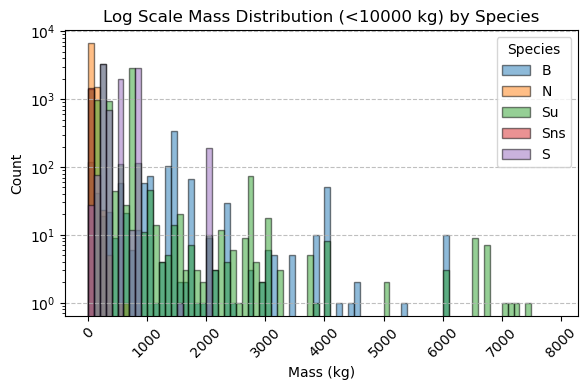

Length of data for B: 1117
Length of data for N: 8170
Length of data for Su: 10048
Length of data for Sns: 1444
Length of data for S: 9206


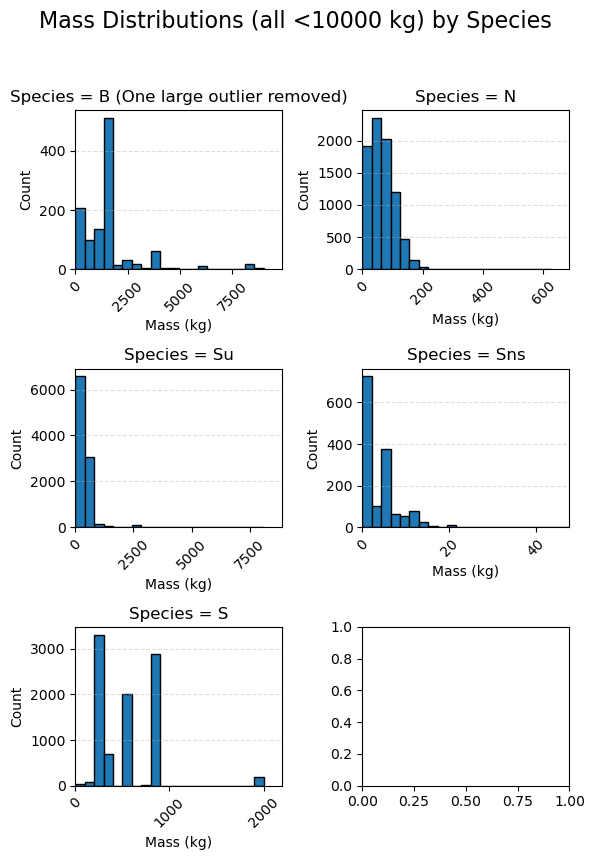

In [11]:
all_species = assigned_df['species_class'].dropna().unique()
bins = np.arange(0, 8000, 100)
plt.figure(figsize=(6,4))

for species in all_species:
    mask = (assigned_df['mass'] < max_mass) & (assigned_df['species_class'] == species)
    subset = assigned_df.loc[mask, 'mass'].dropna()
    # overlay each species, with a bit of transparency
    plt.hist(subset, bins=bins, alpha=0.5, label=species, edgecolor='black')

plt.title(f"Log Scale Mass Distribution (<{max_mass} kg) by Species")
plt.xlabel("Mass (kg)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Species")
plt.yscale('log')

plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()


n = len(all_species)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), sharex=False, sharey=False)
axes = axes.flatten()

for ax, sp in zip(axes, all_species):
    data = assigned_df.loc[
        (assigned_df['species_class']==sp) & 
        (assigned_df['mass'] < max_mass),
        'mass'
    ].dropna()
    
    max_data_mass = data.max() if not data.empty else 0
    print(f"Length of data for {sp}: {len(data)}")

    bins_sp = np.arange(0, max_data_mass + 30, max_data_mass / 20)
    ax.hist(data, bins=bins_sp, edgecolor='black')
    
    if sp != "B":
        ax.set_title(f"Species = {sp}")
    else:
        ax.set_title(f"Species = {sp} (One large outlier removed)")

    if max_data_mass > 1:
        ax.set_xlim(0, max_data_mass+(max_data_mass*0.1))  # Add 10% margin to the max mass
    else:
        ax.set_xlim(0, 1)
    
    ax.set_xlabel("Mass (kg)")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    
    # if sp == "Sns":
    #     print(f"All data for {sp}:\n{data.describe()}")
    #     print(list(data))

fig.suptitle(f"Mass Distributions (all <{max_mass} kg) by Species", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


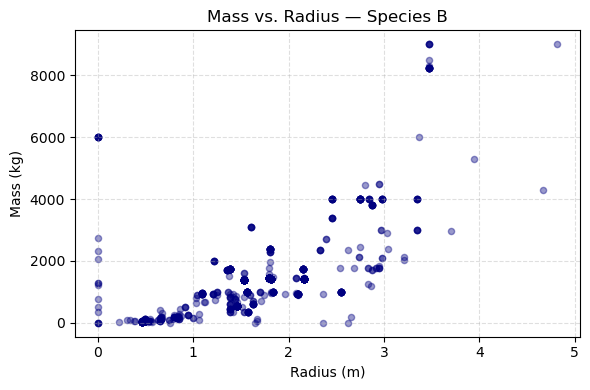

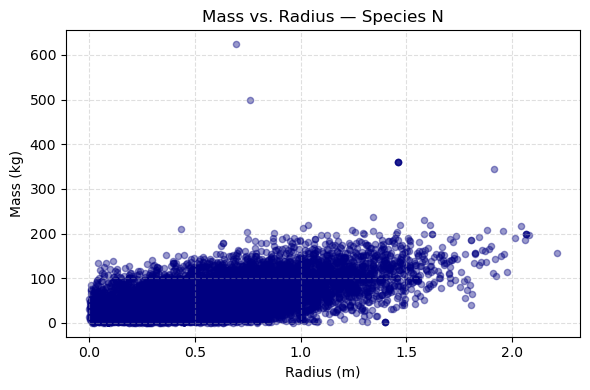

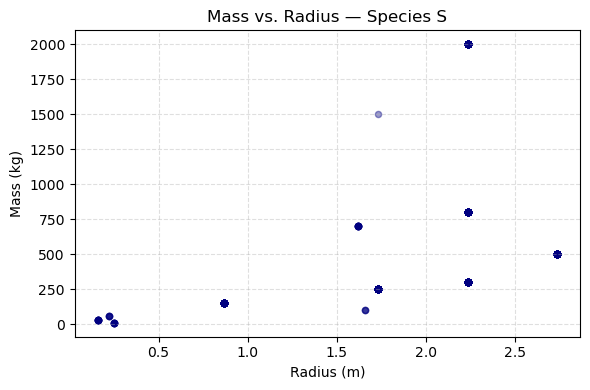

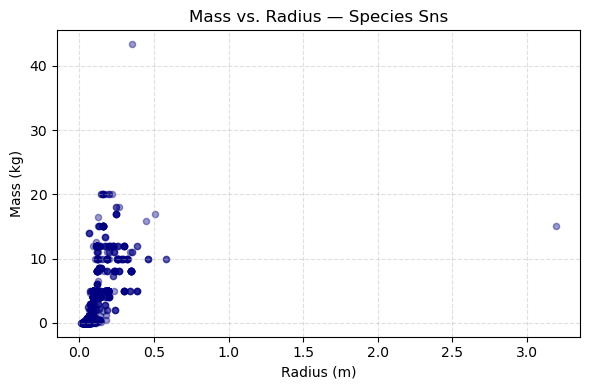

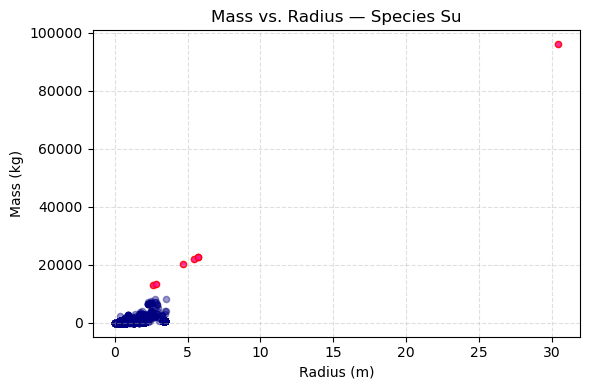

In [12]:
mass_radius_df = assigned_df[['species_class','mass','diam_char']].dropna()
mass_radius_df['radius'] = assigned_df['diam_char'] / 2

for sp, group in mass_radius_df.groupby('species_class'):
    plt.figure(figsize=(6,4))

    
    if remove_outliers:
        big_mass_points = group['mass'] > big_mass
    
    # Plot normal points
    plt.scatter(
        group.loc[~big_mass_points, 'radius'],
        group.loc[~big_mass_points, 'mass'],
        s=20, alpha=0.4, color = 'navy', label='not outlier'
    )

    plt.scatter(
        group.loc[big_mass_points, 'radius'],
        group.loc[big_mass_points, 'mass'],
        s=20, alpha=0.9, color='deeppink', edgecolor='red', label='outlier'
    )
    
    plt.title(f"Mass vs. Radius — Species {sp}")
    plt.xlabel("Radius (m)")
    plt.ylabel("Mass (kg)")
    plt.grid(True, linestyle='--', alpha=0.4)
    
    plt.tight_layout()
    plt.show()

In [13]:
# # how many SnS have small radius?
# print(f"Number of SnS with radius < 0.05 m: {len(mass_radius_df[(mass_radius_df['species_class']=='Sns') & (mass_radius_df['radius'] < 0.05)])}")

# # print out the radii values
# print("Radii of SnS with radius < 0.05 m:")
# print(mass_radius_df[(mass_radius_df['species_class']=='Sns') & (mass_radius_df['radius'] < 0.05)]['radius'].values)

### New Statistical Analysis

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

NOTE: K medoids take much longer to compute. Select the following boolean as needed!

In [15]:
# Set to True to include KMedoids clustering
include_medoids = True  

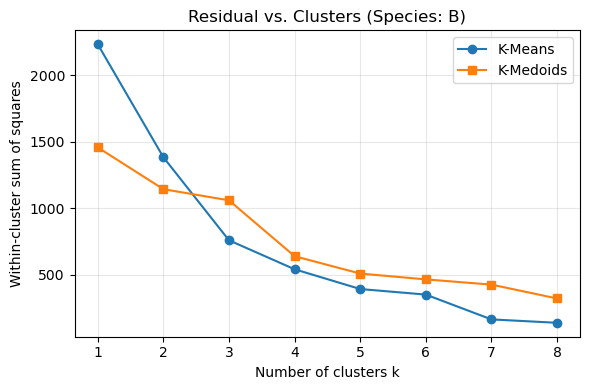

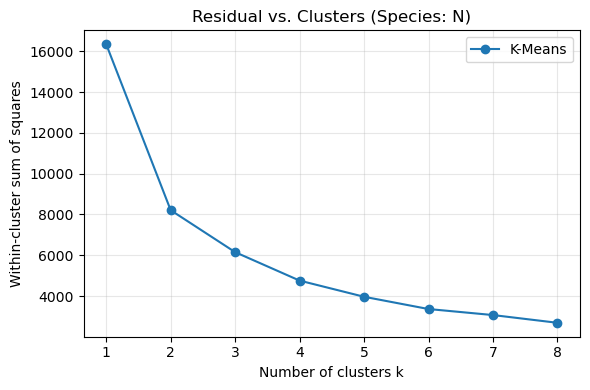

We removed the following S outliers:
Empty DataFrame
Columns: [radius, mass]
Index: []


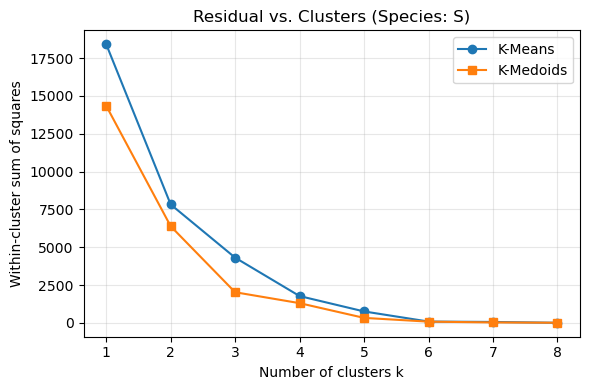

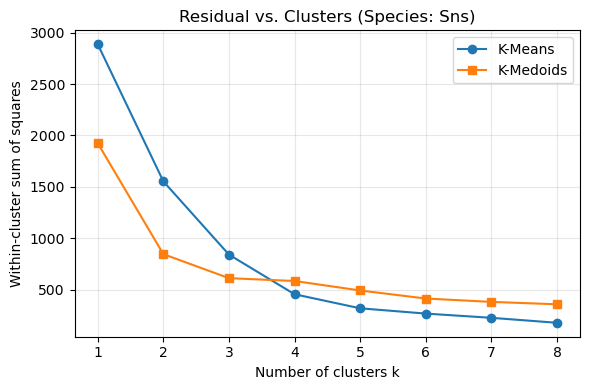

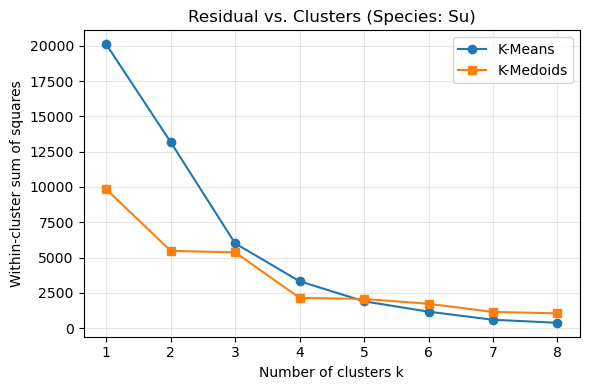

In [16]:
species_groups = mass_radius_df.groupby('species_class')
Xs_by_species = {}
cleaned_groups = {}

for sp, group in species_groups:
    
    # clean up outlier
    if sp == "S":
        S_outliers = group[group['mass'] >= big_mass]
        print("We removed the following S outliers:")
        print(S_outliers[['radius', 'mass']])
        
        group = group[group['mass'] < big_mass]
    cleaned_groups[sp] = group
        
    df = group[['radius', 'mass']].dropna()
    X = df.values
    Xs_by_species[sp] = StandardScaler().fit_transform(X)
    Xs = Xs_by_species[sp] # for use in the loop below
    
    inertia_kmeans  = []
    resid_kmedians  = []
    
    # Computer WCSS (intertia) for k = 1, ..., 8
    ks = range(1,9)
    for k in ks:
        km = KMeans(n_clusters=k, random_state=0).fit(Xs)
        inertia_kmeans.append(km.inertia_)  
        
        # k-medians
        if include_medoids and sp!="N":
            kmn = KMedoids(n_clusters=k, metric='manhattan', init='k-medoids++', random_state=0).fit(Xs)
            # sum of L1 distances to each cluster’s medoid
            # resid = np.sum(kmn.inertia_)  # sklearn_extra uses ‘inertia_’ as sum of distances
            # resid_kmedians.append(resid)
            resid_kmedians.append(kmn.inertia_)
    
    # plot elbow
    plt.figure(figsize=(6, 4))
    plt.plot(ks, inertia_kmeans, '-o', label='K-Means')
    if include_medoids and sp!="N":
        plt.plot(ks, resid_kmedians, '-s', label='K-Medoids')
    plt.xticks(ks)
    plt.xlabel('Number of clusters k')
    plt.ylabel('Within-cluster sum of squares')
    plt.title(f'Residual vs. Clusters (Species: {sp})')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


From this, I think the following # clusters make most sense:
- N: 3
- S: 3

In [17]:
species_names = list(Xs_by_species.keys())
species_names

['B', 'N', 'S', 'Sns', 'Su']

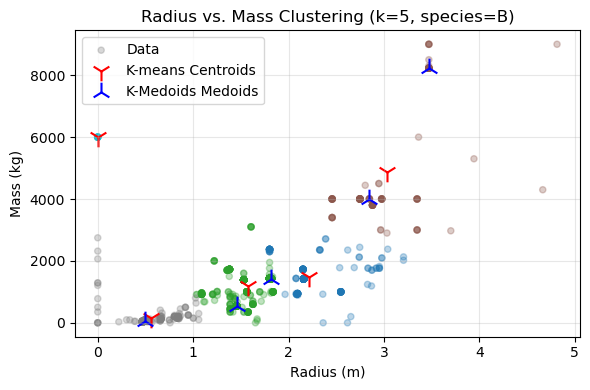

length of data for species B: 1117
K-means centroid coordinates (radius (m), mass (kg)) for species B (k=5):
  Cluster 1: (2.20943, 1486.45583)
  Cluster 2: (1.57247, 1181.08357)
  Cluster 3: (3.03053, 4882.52267)
  Cluster 4: (0.55878, 166.41660)
  Cluster 5: (0.00000, 6000.00000)
K-Medoids centroid coordinates (radius (m), mass (kg)) for species B (k=5):
  Medoid 1: (2.84654, 4006.00000)
  Medoid 2: (1.45571, 545.00000)
  Medoid 3: (3.47005, 8225.97000)
  Medoid 4: (1.82071, 1427.16000)
  Medoid 5: (0.49185, 55.00000)


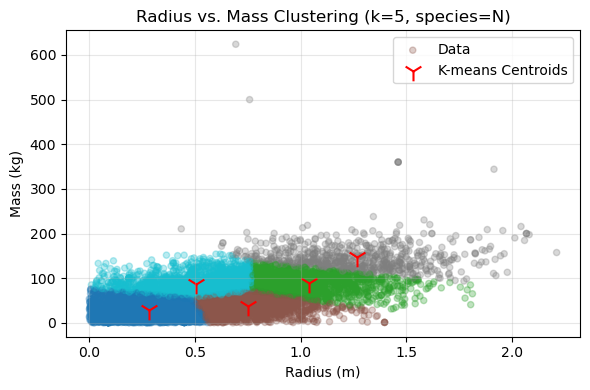

length of data for species N: 8170
K-means centroid coordinates (radius (m), mass (kg)) for species N (k=5):
  Cluster 1: (0.28368, 29.56630)
  Cluster 2: (1.03766, 88.32659)
  Cluster 3: (0.74841, 37.93424)
  Cluster 4: (1.26422, 148.32260)
  Cluster 5: (0.50525, 87.66229)


IndexError: list index out of range

In [19]:
# Cluster fit on K-means
species_names = list(Xs_by_species.keys())
k_list = [5, 5]

for i, sp in enumerate(species_names):
    X = Xs_by_species[sp]
    k = k_list[i]
    group = cleaned_groups[sp]
    
    km = KMeans(n_clusters=k, random_state=0).fit(X)
    labels = km.labels_
    
    # unscale centers before plotting!
    scaler = StandardScaler().fit(group[['radius', 'mass']].dropna().values)
    centers_scaled = km.cluster_centers_
    centers_unscaled = scaler.inverse_transform(centers_scaled)
    
    if include_medoids and sp != "N":
        kmn = KMedoids(n_clusters=k, metric='manhattan', init='k-medoids++', random_state=0).fit(X)
        labels_medoids = kmn.labels_
        medoids = kmn.cluster_centers_
        medoids_unscaled = scaler.inverse_transform(medoids)

    
    df = group[['radius', 'mass']].dropna()
    
    plt.figure(figsize=(6, 4))
    plt.scatter(df['radius'], df['mass'], c=labels, cmap='tab10', s=20, alpha=0.3, label='Data')
    plt.scatter(centers_unscaled[:, 0], centers_unscaled[:, 1],
                marker='1', c='red', s=200, label='K-means Centroids')
    if include_medoids and sp != "N":
        plt.scatter(medoids_unscaled[:, 0], medoids_unscaled[:, 1],
                marker='2', c='blue', s=200, label='K-Medoids Medoids' if include_medoids else None)
    plt.xlabel('Radius (m)')
    plt.ylabel('Mass (kg)')
    plt.title(f'Radius vs. Mass Clustering (k={k}, species={sp})')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"length of data for species {sp}: {len(df)}")
    
    print(f"K-means centroid coordinates (radius (m), mass (kg)) for species {sp} (k={k}):")
    for j, center in enumerate(centers_unscaled):
        print(f"  Cluster {j+1}: ({center[0]:.5f}, {center[1]:.5f})")
     
    if include_medoids and sp != "N":
        print(f"K-Medoids centroid coordinates (radius (m), mass (kg)) for species {sp} (k={k}):")
        for j, medoid in enumerate(medoids_unscaled):
            print(f"  Medoid {j+1}: ({medoid[0]:.5f}, {medoid[1]:.5f})")
    

You should follow K-Means for determining the optimal number of clusters for Species S.
Here's the reasoning:

 - Lower WCSS for k >= 2: Although K-Medoids starts with a lower Within-cluster sum of squares (WCSS) at k=1, for any number of clusters from k=2 onwards, the K-Means algorithm (blue line) consistently achieves a lower WCSS than K-Medoids (orange line). A lower WCSS indicates a better clustering result (tighter clusters).
 - Clearer "Elbow" for K-Means: Both algorithms still show a strong "elbow" at k=3, indicating that 3 clusters is likely the optimal choice where the benefit of adding more clusters diminishes significantly. The K-Means elbow is still very pronounced, making it a reliable indicator.
